In [1]:
# ============================================================
# 0) SETUP & INSTALL
# ============================================================
!pip -q install scikit-optimize optuna tensorflow --progress-bar off

import os, math, json, warnings, random
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical

import optuna
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, optimizers

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# Konfigurasi iterasi / trial (sesuaikan jika runtime terbatas)
N_ITER_RF = 30        # BayesSearchCV untuk Random Forest
N_TRIALS_LSTM = 30    # Optuna trials untuk LSTM

# ============================================================
# 1) HELPER: UTILITAS NAMA KOLOM & DETEKSI
# ============================================================
def normalize_col(c: str) -> str:
    c = str(c).strip().lower()
    # ganti spasi/delimiter umum
    for ch in [" ", "-", ".", ",", "/", "(", ")", "[", "]"]:
        c = c.replace(ch, "_")
    # rapikan underscore berlebih
    while "__" in c:
        c = c.replace("__", "_")
    return c.strip("_")

def find_col(cols, substrs):
    """Cari kolom yang mengandung semua substr dalam nama (casefolded)."""
    for c in cols:
        low = c.lower()
        if all(s in low for s in substrs):
            return c
    return None

def metric_report(y_true, y_pred, label=""):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred)
    print(f"[{label}]  R2={r2:.4f} | MAE={mae:.4f} | RMSE={rmse:.4f}")
    return {"r2": r2, "mae": mae, "rmse": rmse}

def plot_scatter(y_true, y_pred, title):
    plt.figure(figsize=(5,5))
    plt.scatter(y_true, y_pred, alpha=0.5)
    mn, mx = min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())
    plt.plot([mn, mx], [mn, mx])
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.grid(True)
    plt.show()

def plot_residual(y_true, y_pred, title):
    resid = y_pred - y_true
    plt.figure(figsize=(6,4))
    plt.scatter(y_true, resid, alpha=0.5)
    plt.axhline(0, linestyle="--")
    plt.xlabel("Actual")
    plt.ylabel("Residual (Pred - Actual)")
    plt.title(title)
    plt.grid(True)
    plt.show()

In [2]:
# ============================================================
# 2) LOAD DATA (PILIH 2A ATAU 2B)
# ============================================================

# --- 2A) UPLOAD LANGSUNG (pilih ini jika file di komputer lokal) ---
USE_UPLOAD = True   # set True untuk upload manual; set False jika pakai Google Drive (2B)
EXCEL_PATH = None   # akan diisi otomatis jika upload

if USE_UPLOAD:
    from google.colab import files
    uploaded = files.upload()  # pilih file Excel kamu (mis: "eucalyptus_data_new Yang  ada Curah Hujan ok.xlsx")
    EXCEL_PATH = next(iter(uploaded.keys()))  # nama file pertama yang diupload

# --- 2B) GOOGLE DRIVE (pilih ini jika file di Google Drive) ---
# Jika ingin pakai Drive, set USE_UPLOAD=False di atas, lalu mount drive & set path file:
if not USE_UPLOAD:
    from google.colab import drive
    drive.mount('/content/drive')
    # Ganti path di bawah dengan lokasi file kamu di Drive
    EXCEL_PATH = "/content/sample_data/eucalyptus_data_new Yang  ada Curah Hujan ok.xlsx"

# Baca Excel
assert EXCEL_PATH is not None, "Path file Excel belum di-set."
df = pd.read_excel(EXCEL_PATH)

print("== SHAPE ==")
print(df.shape)
print("\n== HEAD (5) BEFORE NORMALIZE ==")
print(df.head())

# Normalisasi nama kolom
orig_cols = df.columns.tolist()
norm_cols = [normalize_col(c) for c in orig_cols]
df.columns = norm_cols

print("\n== COLUMNS (NORMALIZED) ==")
print(df.columns.tolist())

Saving eucalyptus_data_ok.xlsx to eucalyptus_data_ok.xlsx
== SHAPE ==
(1500, 14)

== HEAD (5) BEFORE NORMALIZE ==
             Timestamp  Suhu Udara (°C)  Kelembaban Udara (%)  \
0  2025-08-27 08:02:41             21.4                  50.9   
1  2025-08-27 08:03:09             25.2                  52.8   
2  2025-08-27 08:03:10             21.1                  54.1   
3  2025-08-27 08:03:17             26.2                  56.3   
4  2025-08-27 08:03:22             24.7                  48.3   

   Suhu Tanah (°C)  Kelembaban Tanah (%)  pH Tanah  Nitrogen (mg/kg)  \
0             28.4                  76.4      4.43                62   
1             26.5                  66.1      7.37                64   
2             28.3                  70.1      6.54               103   
3             30.2                  71.5      6.60               102   
4             26.4                  40.3      7.06                98   

   Fosfor (mg/kg)  Kalium (mg/kg) Status Kesuburan  \
0       

In [3]:
# ============================================================
# 3) AUDIT DASAR
# ============================================================
print("\n== INFO ==")
print(df.info())

print("\n== DESCRIPTIVE STATS (NUMERIC) ==")
print(df.describe().T)

# Kandidat fitur & target (robust ke variasi ejaan)
features_map = {
    "suhu_udara": find_col(df.columns, ["suhu", "udara"]),
    "kelembapan_udara": find_col(df.columns, ["kelembab", "udara"]),  # kelembaban/kelembapan
    "suhu_tanah": find_col(df.columns, ["suhu", "tanah"]),
    "kelembapan_tanah": find_col(df.columns, ["kelembab", "tanah"]),
    "ph_tanah": find_col(df.columns, ["ph", "tanah"]),
    "nitrogen": find_col(df.columns, ["nitrogen"]),
    "fosfor": find_col(df.columns, ["fosfor"]),
    "kalium": find_col(df.columns, ["kalium"]),
    "curah_hujan": find_col(df.columns, ["curah", "hujan"]),
}
target_col = find_col(df.columns, ["waktu", "tanam"])

features = [v for v in features_map.values() if v is not None]
missing_keys = [k for k, v in features_map.items() if v is None]

print("\n== DETECTED FEATURES ==")
print(features)
print("Missing feature keys (if any):", missing_keys)
print("Detected target:", target_col)

# Audit nol & NaN di kolom numerik
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
audit_zero = df[num_cols].eq(0).sum().sort_values(ascending=False).head(20)
audit_nan = df[num_cols].isna().sum().sort_values(ascending=False).head(20)
print("\n== TOP ZERO-COUNTS (NUMERIC) ==")
print(audit_zero)
print("\n== TOP NaN-COUNTS (NUMERIC) ==")
print(audit_nan)



== INFO ==
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   timestamp           1500 non-null   object 
 1   suhu_udara_°c       1500 non-null   float64
 2   kelembaban_udara_%  1500 non-null   float64
 3   suhu_tanah_°c       1500 non-null   float64
 4   kelembaban_tanah_%  1500 non-null   float64
 5   ph_tanah            1500 non-null   float64
 6   nitrogen_mg_kg      1500 non-null   int64  
 7   fosfor_mg_kg        1500 non-null   int64  
 8   kalium_mg_kg        1500 non-null   int64  
 9   status_kesuburan    1500 non-null   object 
 10  rekomendasi         1500 non-null   object 
 11  curah_hujan_mm      1500 non-null   float64
 12  lokasi              1500 non-null   object 
 13  waktu_tanam         1500 non-null   int64  
dtypes: float64(6), int64(4), object(4)
memory usage: 164.2+ KB
None

== DESCRIPTIVE STATS (NUMER

In [4]:
# ============================================================
# 4) PREPROCESSING
#    - 0 -> NaN di kolom fitur
#    - Imputasi median
#    - Train/test split
# ============================================================
assert target_col is not None, "Kolom target (waktu tanam) tidak terdeteksi. Cek nama kolom di Excel."

X_raw = df[features].copy()
y = df[target_col].copy()

# Ganti 0 => NaN hanya di fitur (sesuai definisi dataset kamu)
X_raw = X_raw.mask(X_raw == 0, np.nan)

print("\n== MISSING PER FEATURE (SEBELUM IMPUTE) ==")
print(X_raw.isna().sum().sort_values(ascending=False))

imputer = SimpleImputer(strategy="median")
X_imp = pd.DataFrame(imputer.fit_transform(X_raw), columns=features, index=df.index)

X_train, X_test, y_train, y_test = train_test_split(
    X_imp, y, test_size=0.2, random_state=SEED
)

print("\n== SHAPES ==")
print("X_train:", X_train.shape, "| X_test:", X_test.shape)


== MISSING PER FEATURE (SEBELUM IMPUTE) ==
fosfor_mg_kg          60
nitrogen_mg_kg        51
kalium_mg_kg          49
curah_hujan_mm        11
suhu_udara_°c          0
ph_tanah               0
kelembaban_tanah_%     0
suhu_tanah_°c          0
kelembaban_udara_%     0
dtype: int64

== SHAPES ==
X_train: (1200, 9) | X_test: (300, 9)



===== BASELINE =====
[LinearRegression]  R2=0.2821 | MAE=15.5398 | RMSE=461.9407
[RF Default]  R2=0.9075 | MAE=3.0795 | RMSE=59.5171


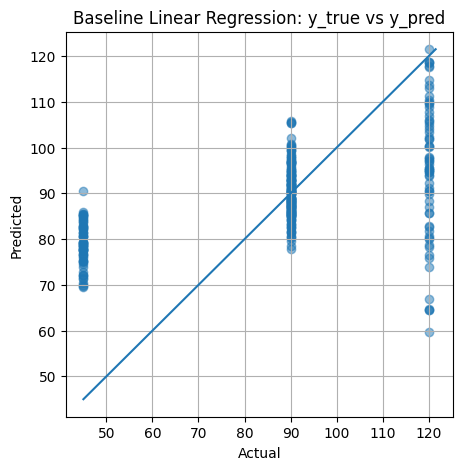

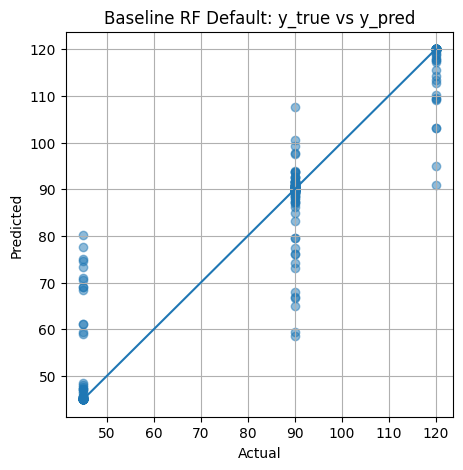

In [5]:
# ============================================================
# 5) BASELINE (Linear Regression & RF default)
# ============================================================
print("\n===== BASELINE =====")
linreg = LinearRegression()
linreg.fit(X_train, y_train)
pred_lr = linreg.predict(X_test)
metrics_lr = metric_report(y_test, pred_lr, label="LinearRegression")

rf_default = RandomForestRegressor(random_state=SEED, n_jobs=-1)
rf_default.fit(X_train, y_train)
pred_rf_def = rf_default.predict(X_test)
metrics_rf_def = metric_report(y_test, pred_rf_def, label="RF Default")

plot_scatter(y_test.values, pred_lr, "Baseline Linear Regression: y_true vs y_pred")
plot_scatter(y_test.values, pred_rf_def, "Baseline RF Default: y_true vs y_pred")


===== RANDOM FOREST + BAYES SEARCH =====
Best RF params: OrderedDict({'max_depth': 22, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100})
[RF (Bayes tuned)]  R2=0.8934 | MAE=4.4045 | RMSE=68.6116


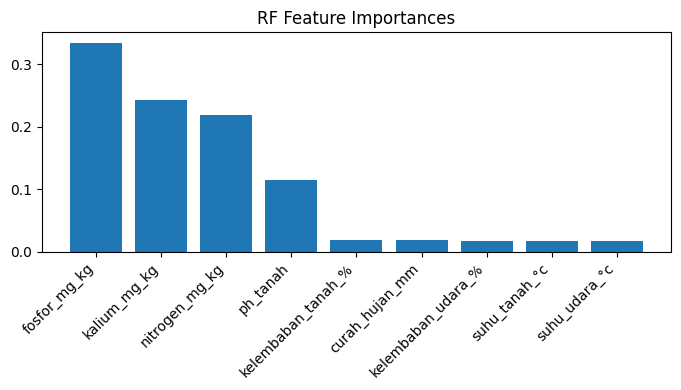

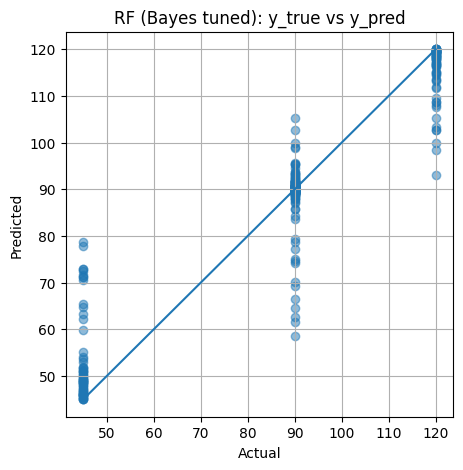

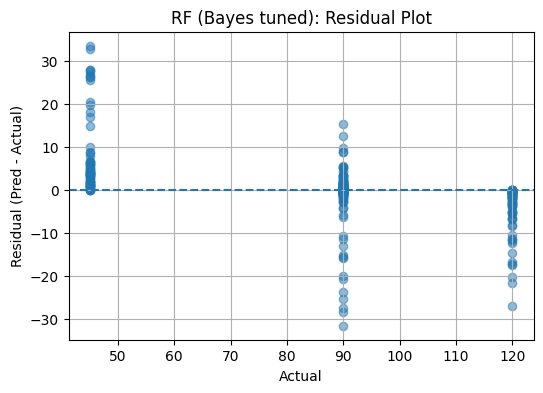

In [6]:
# ============================================================
# 6) RANDOM FOREST + BAYESIAN OPTIMIZATION (skopt)
# ============================================================
print("\n===== RANDOM FOREST + BAYES SEARCH =====")
rf = RandomForestRegressor(random_state=SEED, n_jobs=-1)
search_space = {
    "n_estimators": Integer(100, 700),
    "max_depth": Integer(3, 40),
    "min_samples_split": Integer(2, 20),
    "min_samples_leaf": Integer(1, 10),
    "max_features": Categorical(["sqrt", "log2"])
}

bayes_rf = BayesSearchCV(
    estimator=rf,
    search_spaces=search_space,
    n_iter=N_ITER_RF,
    cv=5,
    scoring="neg_root_mean_squared_error",
    random_state=SEED,
    n_jobs=-1,
    verbose=0
)

bayes_rf.fit(X_train, y_train)
rf_best = bayes_rf.best_estimator_
print("Best RF params:", bayes_rf.best_params_)

pred_rf_best = rf_best.predict(X_test)
metrics_rf_best = metric_report(y_test, pred_rf_best, label="RF (Bayes tuned)")

# Feature importance plot
importances = getattr(rf_best, "feature_importances_", None)
if importances is not None:
    idx = np.argsort(importances)[::-1]
    plt.figure(figsize=(7,4))
    plt.bar(range(len(features)), np.array(importances)[idx])
    plt.xticks(range(len(features)), np.array(features)[idx], rotation=45, ha="right")
    plt.title("RF Feature Importances")
    plt.tight_layout()
    plt.show()

plot_scatter(y_test.values, pred_rf_best, "RF (Bayes tuned): y_true vs y_pred")
plot_residual(y_test.values, pred_rf_best, "RF (Bayes tuned): Residual Plot")

[I 2025-10-17 13:57:55,416] A new study created in memory with name: no-name-06d26db1-cf41-494b-b43a-6bc7001c4c73



===== LSTM + OPTUNA BAYESIAN =====


[I 2025-10-17 13:58:11,984] Trial 0 finished with value: 11.390222549438477 and parameters: {'units': 225, 'dense_width': 250, 'dropout': 0.35535960322426546, 'lr': 0.002905657838920861, 'batch_size': 41, 'epochs': 99}. Best is trial 0 with value: 11.390222549438477.
[I 2025-10-17 13:58:21,227] Trial 1 finished with value: 11.307920455932617 and parameters: {'units': 200, 'dense_width': 221, 'dropout': 0.2650909527157331, 'lr': 0.00795793644706399, 'batch_size': 101, 'epochs': 59}. Best is trial 1 with value: 11.307920455932617.
[I 2025-10-17 13:58:51,603] Trial 2 finished with value: 17.35335922241211 and parameters: {'units': 211, 'dense_width': 168, 'dropout': 0.2073062309853072, 'lr': 0.00013492310666316523, 'batch_size': 54, 'epochs': 181}. Best is trial 1 with value: 11.307920455932617.
[I 2025-10-17 13:59:00,728] Trial 3 finished with value: 12.755707740783691 and parameters: {'units': 70, 'dense_width': 184, 'dropout': 0.46523281076609435, 'lr': 0.00262586330508066, 'batch_size

Best LSTM trial: 1
Best LSTM params: {'units': 200, 'dense_width': 221, 'dropout': 0.2650909527157331, 'lr': 0.00795793644706399, 'batch_size': 101, 'epochs': 59}
Best LSTM val_RMSE: 11.307920455932617
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[LSTM (Bayes tuned)]  R2=0.7777 | MAE=8.9676 | RMSE=143.0291


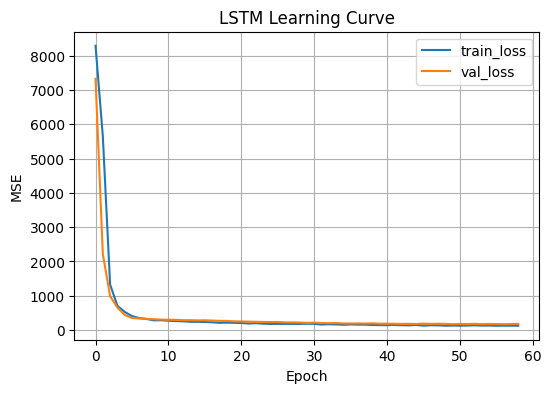

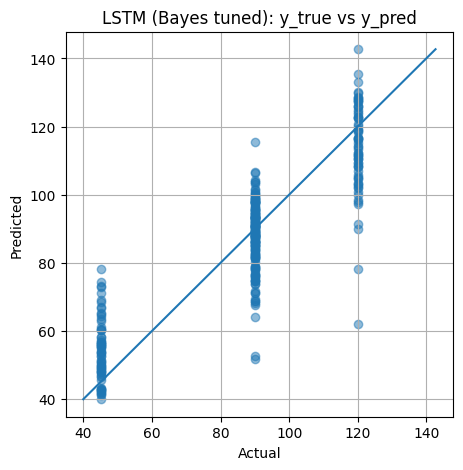

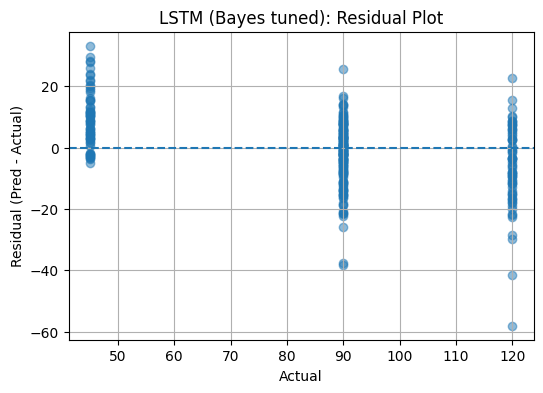

In [7]:
# ============================================================
# 7) LSTM + BAYESIAN OPTIMIZATION (Optuna)
#    Data tabular harian multi-lokasi (bukan time series),
#    jadi kita bentuk input (n_samples, 1, n_features).
# ============================================================
print("\n===== LSTM + OPTUNA BAYESIAN =====")

# Scaling khusus LSTM
scaler = StandardScaler().fit(X_train)
Xtr_scaled = scaler.transform(X_train)
Xte_scaled = scaler.transform(X_test)

# reshape ke (samples, timesteps=1, features)
Xtr_seq = Xtr_scaled.reshape((-1, 1, Xtr_scaled.shape[1]))
Xte_seq = Xte_scaled.reshape((-1, 1, Xte_scaled.shape[1]))

# validasi holdout kecil dari train (supaya objective Optuna konsisten & cepat)
Xtr_sub, Xval_sub, ytr_sub, yval_sub = train_test_split(
    Xtr_seq, y_train.values, test_size=0.2, random_state=SEED
)

def build_lstm_model(input_shape, units=64, dense_width=64, dropout=0.2, lr=1e-3):
    model = keras.Sequential()
    model.add(layers.Input(shape=input_shape))
    model.add(layers.LSTM(units))
    if dropout > 0:
        model.add(layers.Dropout(dropout))
    model.add(layers.Dense(dense_width, activation="relu"))
    model.add(layers.Dense(1))
    opt = optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss="mse", metrics=[keras.metrics.RootMeanSquaredError()])
    return model

def objective(trial: optuna.Trial):
    units = trial.suggest_int("units", 32, 256)
    dense_width = trial.suggest_int("dense_width", 32, 256)
    dropout = trial.suggest_float("dropout", 0.0, 0.5)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_int("batch_size", 16, 128, log=True)
    epochs = trial.suggest_int("epochs", 50, 200)

    model = build_lstm_model(
        input_shape=(Xtr_seq.shape[1], Xtr_seq.shape[2]),
        units=units, dense_width=dense_width, dropout=dropout, lr=lr
    )
    es = callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=0)
    hist = model.fit(
        Xtr_sub, ytr_sub,
        validation_data=(Xval_sub, yval_sub),
        epochs=epochs, batch_size=batch_size, verbose=0,
        callbacks=[es]
    )
    # gunakan RMSE pada validasi sebagai objective
    val_rmse = np.min(hist.history["val_root_mean_squared_error"])
    return val_rmse

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=N_TRIALS_LSTM, show_progress_bar=False)

print("Best LSTM trial:", study.best_trial.number)
print("Best LSTM params:", study.best_trial.params)
print("Best LSTM val_RMSE:", study.best_value)

# Latih ulang model LSTM terbaik pada full train (dengan val split)
best_params = study.best_trial.params
lstm_best = build_lstm_model(
    input_shape=(Xtr_seq.shape[1], Xtr_seq.shape[2]),
    units=best_params.get("units", 64),
    dense_width=best_params.get("dense_width", 64),
    dropout=best_params.get("dropout", 0.2),
    lr=best_params.get("lr", 1e-3),
)
es_final = callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=0)
hist_final = lstm_best.fit(
    Xtr_scaled.reshape((-1,1,Xtr_scaled.shape[1])), y_train.values,
    validation_split=0.2,
    epochs=best_params.get("epochs", 100),
    batch_size=best_params.get("batch_size", 32),
    verbose=0,
    callbacks=[es_final]
)

# Evaluasi di test
pred_lstm = lstm_best.predict(Xte_seq).ravel()
metrics_lstm = metric_report(y_test.values, pred_lstm, label="LSTM (Bayes tuned)")

# Plot learning curve
plt.figure(figsize=(6,4))
plt.plot(hist_final.history["loss"], label="train_loss")
plt.plot(hist_final.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("LSTM Learning Curve")
plt.legend()
plt.grid(True)
plt.show()

plot_scatter(y_test.values, pred_lstm, "LSTM (Bayes tuned): y_true vs y_pred")
plot_residual(y_test.values, pred_lstm, "LSTM (Bayes tuned): Residual Plot")


===== XGBOOST + BAYES SEARCH =====
Best XGB params: OrderedDict({'colsample_bytree': 0.8294832643164352, 'gamma': 1.8834638448778307, 'learning_rate': 0.011548586902807178, 'max_depth': 11, 'min_child_weight': 1.5180194330468615, 'n_estimators': 1202, 'reg_alpha': 0.004056616539577368, 'reg_lambda': 0.0006702816495004686, 'subsample': 0.8847959385884958})
[XGB (Bayes tuned)]  R2=0.9161 | MAE=3.7744 | RMSE=53.9708


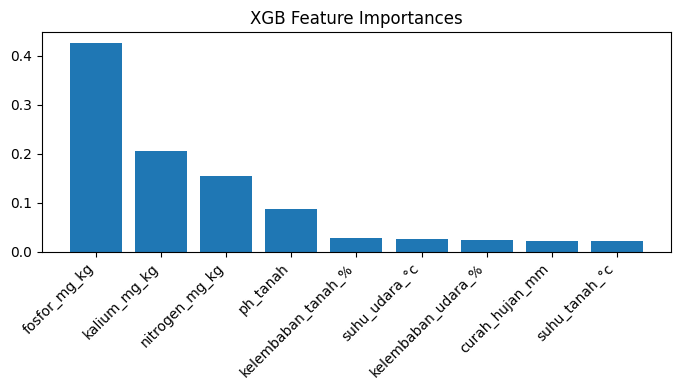

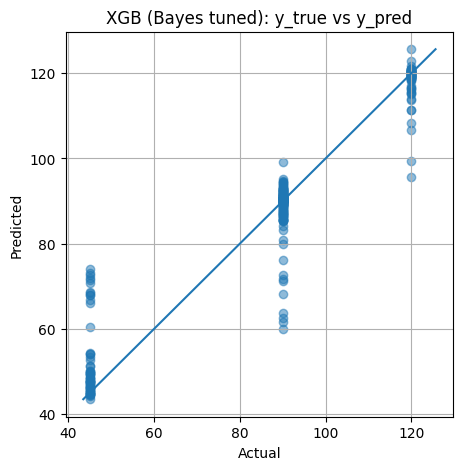

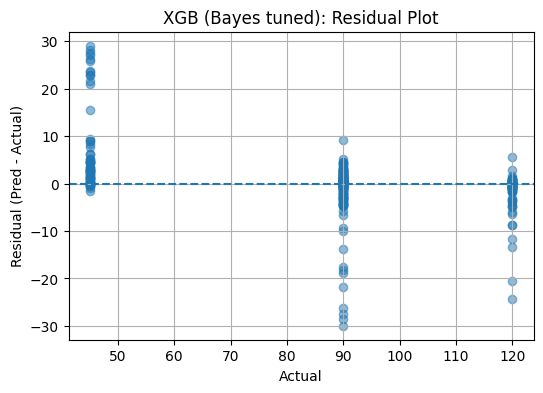

In [8]:
# ============================================================
# 8) XGBOOST + BAYESIAN OPTIMIZATION (skopt)
#    (Letakkan bagian ini setelah RF dan sebelum LSTM)
# ============================================================
print("\n===== XGBOOST + BAYES SEARCH =====")

# Jika belum terpasang:
# !pip install xgboost

from xgboost import XGBRegressor

# Gunakan iterasi terpisah agar fleksibel; fallback ke 50 jika tidak ada
N_ITER_XGB = globals().get("N_ITER_XGB", globals().get("N_ITER_RF", 50))

xgb_base = XGBRegressor(
    objective="reg:squarederror",
    random_state=SEED,
    n_jobs=-1,
    tree_method="hist"  # cepat & stabil
)

search_space_xgb = {
    "n_estimators": Integer(200, 1500),
    "max_depth": Integer(3, 12),
    "learning_rate": Real(1e-3, 3e-1, prior="log-uniform"),
    "subsample": Real(0.5, 1.0),
    "colsample_bytree": Real(0.5, 1.0),
    "min_child_weight": Real(1e-2, 10, prior="log-uniform"),
    "reg_alpha": Real(1e-8, 10, prior="log-uniform"),
    "reg_lambda": Real(1e-8, 10, prior="log-uniform"),
    "gamma": Real(0.0, 5.0)
}

bayes_xgb = BayesSearchCV(
    estimator=xgb_base,
    search_spaces=search_space_xgb,
    n_iter=N_ITER_XGB,
    cv=5,
    scoring="neg_root_mean_squared_error",
    random_state=SEED,
    n_jobs=-1,
    verbose=0
)

bayes_xgb.fit(X_train, y_train)

xgb_best = bayes_xgb.best_estimator_
print("Best XGB params:", bayes_xgb.best_params_)

pred_xgb_best = xgb_best.predict(X_test)
metrics_xgb_best = metric_report(y_test.values, pred_xgb_best, label="XGB (Bayes tuned)")

# Feature importance (gain-based)
importances = getattr(xgb_best, "feature_importances_", None)
if importances is not None:
    idx = np.argsort(importances)[::-1]
    plt.figure(figsize=(7,4))
    plt.bar(range(len(features)), np.array(importances)[idx])
    plt.xticks(range(len(features)), np.array(features)[idx], rotation=45, ha="right")
    plt.title("XGB Feature Importances")
    plt.tight_layout()
    plt.show()

plot_scatter(y_test.values, pred_xgb_best, "XGB (Bayes tuned): y_true vs y_pred")
plot_residual(y_test.values, pred_xgb_best, "XGB (Bayes tuned): Residual Plot")



===== COMPARISON =====
Baseline LinearRegression: {'r2': 0.28214338408377415, 'mae': 15.539755270931849, 'rmse': 461.94073234209134}
Baseline RF Default     : {'r2': 0.907510372960373, 'mae': 3.0795, 'rmse': 59.51707499999999}
RF (Bayes tuned)        : {'r2': 0.8933775058275059, 'mae': 4.4045, 'rmse': 68.61157500000002}
LSTM (Bayes tuned)      : {'r2': 0.7777325510978699, 'mae': 8.967573165893555, 'rmse': 143.02911376953125}


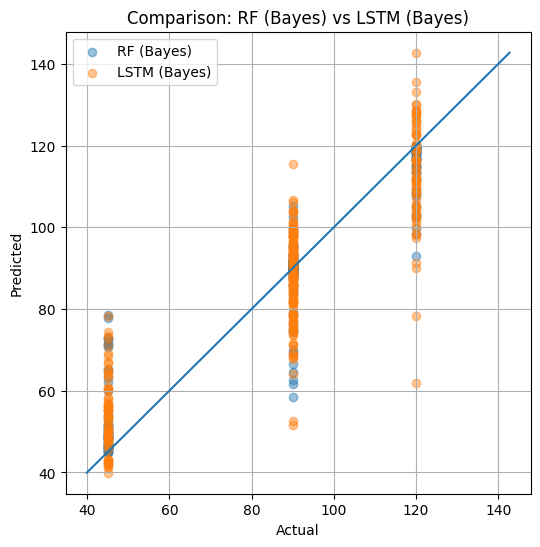

In [9]:
# ============================================================
# 8) EVALUASI & PERBANDINGAN
# ============================================================
print("\n===== COMPARISON =====")
print("Baseline LinearRegression:", metrics_lr)
print("Baseline RF Default     :", metrics_rf_def)
print("RF (Bayes tuned)        :", metrics_rf_best)
print("LSTM (Bayes tuned)      :", metrics_lstm)

# Scatter gabungan (opsional)
plt.figure(figsize=(6,6))
plt.scatter(y_test.values, pred_rf_best, alpha=0.45, label="RF (Bayes)")
plt.scatter(y_test.values, pred_lstm, alpha=0.45, label="LSTM (Bayes)")
mn = min(y_test.min(), pred_rf_best.min(), pred_lstm.min())
mx = max(y_test.max(), pred_rf_best.max(), pred_lstm.max())
plt.plot([mn, mx], [mn, mx])
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Comparison: RF (Bayes) vs LSTM (Bayes)")
plt.legend()
plt.grid(True)
plt.show()